# Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix

# Loading the Files

Download the csv files into the `data/` directory.

Train shape: (1697533, 9)
Test shape: (212192, 2)
First few rows of training data:
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bitter

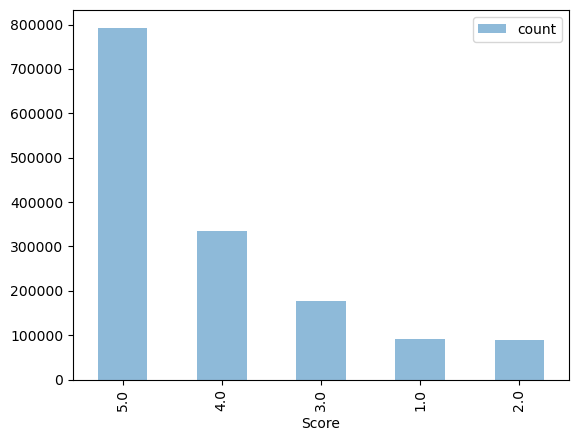


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [5]:
trainingSet = pd.read_csv('/users/anajoshi/Downloads/train.csv')
testingSet = pd.read_csv('/users/anajoshi/Downloads/test.csv')

print("Train shape:", trainingSet.shape)
print("Test shape:", testingSet.shape)

# Display the first few rows of the training data
print("First few rows of training data:")
print(trainingSet.head())

# Check for missing values in the training data
print("Missing values in training data:")
print(trainingSet.isnull().sum())

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


# Adding Features

In [6]:
def add_features_to(df):
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].replace(0, np.nan)
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Review_Year'] = df['Time'].dt.year
    df['Review_Month'] = df['Time'].dt.month
    df['Review_Day'] = df['Time'].dt.day

    df['Summary'] = df['Summary'].fillna('')
    df['Text'] = df['Text'].fillna('')

    df['Summary_length'] = df['Summary'].apply(len)
    df['Text_length'] = df['Text'].apply(len)

    df['Summary_word_count'] = df['Summary'].apply(lambda x: len(x.split()))
    df['Text_word_count'] = df['Text'].apply(lambda x: len(x.split()))

    return df

trainingSet = add_features_to(trainingSet)


# Data preparation

In [7]:
train_data = trainingSet[trainingSet['Score'].notnull()].copy()

test_data = pd.merge(testingSet[['Id']], trainingSet.drop(columns=['Score']), on='Id', how='left')

missing_ids = set(testingSet['Id']) - set(test_data['Id'])

train_data['Combined_Text'] = train_data['Summary'] + ' ' + train_data['Text']
test_data['Combined_Text'] = test_data['Summary'] + ' ' + test_data['Text']


# Text Vectorization

In [8]:
combined_data = pd.concat([train_data['Combined_Text'], test_data['Combined_Text']], axis=0)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

tfidf_combined_text = tfidf_vectorizer.fit_transform(combined_data)

tfidf_train = tfidf_combined_text[:len(train_data)]
tfidf_test = tfidf_combined_text[len(train_data):]

#  Numerical Features

In [9]:
numeric_features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness',
    'Summary_length', 'Text_length', 'Summary_word_count', 'Text_word_count',
    'Review_Year', 'Review_Month', 'Review_Day'
]

X_train_numeric = train_data[numeric_features].fillna(0)
X_test_numeric = test_data[numeric_features].fillna(0)

# Combining Features


In [10]:
X_train_num_sparse = csr_matrix(X_train_numeric.values)
X_test_num_sparse = csr_matrix(X_test_numeric.values)

X_train_combined = hstack([tfidf_train, X_train_num_sparse])
X_test_combined = hstack([tfidf_test, X_test_num_sparse])

y_train = train_data['Score']

# Model Building and Evaluation

In [11]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train_combined, y_train, test_size=0.25, random_state=42)

svd = TruncatedSVD(n_components=100)
X_train_reduced = svd.fit_transform(X_train_combined)
X_train_part_reduced = svd.transform(X_train_part)
X_valid_reduced = svd.transform(X_valid)

rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_part_reduced, y_train_part)

# Predict and evaluate Random Forest Classifier
y_pred_rf = rf_classifier.predict(X_valid_reduced)
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print("Random Forest Classifier Accuracy:", accuracy_rf)

Random Forest Classifier Accuracy: 0.5892237757718077


# Select model (not needed anymore)

In [12]:
print("\nModel Accuracies:")
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")

accuracies = {
    'Random Forest Classifier': accuracy_rf
}

best_model_name = max(accuracies, key=accuracies.get)
print(f"\nBest model based on validation accuracy: {best_model_name}")


Model Accuracies:
Random Forest Classifier Accuracy: 0.5892237757718077

Best model based on validation accuracy: Random Forest Classifier


# Model on full data

In [13]:
X_train_reduced_full = svd.fit_transform(X_train_combined)
X_test_reduced = svd.transform(X_test_combined)
best_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
best_model.fit(X_train_reduced_full, y_train)
y_test_pred = best_model.predict(X_test_reduced)


submission = testingSet[['Id']].copy()
submission['Score'] = y_test_pred

submission.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")



Submission file created successfully!


# Submission CSV file

In [ ]:
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")